## Prepare input data

This notebook helps you load the experimental data from an excel file or a csv file, and plot it

Then you can use the next part to generate a config file for the bayesian inference 

In [1]:
# load the relevant modules for the analysis

from pl_temp_fit import Exp_data_utils

import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import os
import json
import uuid
import numpy as np
from pl_temp_fit import config_utils
from pl_temp_fit import covariance_utils, generate_data_utils, fit_EL_utils
import pandas as pd
import glob
from scipy import interpolate
# access the right directory
#os.chdir('/rds/general/user/ma11115/home/pl_temp_fit/') 

#os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [2]:
# Process the input data 
# if the data are in xlsx format convert them to csv

def from_xslx_to_csv(csv_name):
    data = pd.read_excel(csv_name)
    hws = np.arange(0.95, 1.8, 0.01)
    y = np.zeros((hws.size, len(data.values[0,:])))
    y[:,0] = hws
    for i in range(1,len(data.values[0,:])):
        f = interpolate.interp1d(data.values[1:,0], data.values[1:,i], axis=0, fill_value='extrapolate')
        y[:,i] = f(hws)
    data = pd.DataFrame(y, columns=data.columns,index=None)  
    data = data.transpose()
    data = data.rename(columns=data.iloc[0])[1:]
    if data.shape[0]>8:
        data = data.iloc[range(0,data.shape[0],2),:]
    data.to_csv(f'{csv_name.replace(".xlsx",".csv")}')
    return f'{csv_name.replace(".xlsx",".csv")}'
xlsx_files = glob.glob('experiemental_data/2023-12-12-Lowtemp-PL/*.xlsx')
for xlsx_file in xlsx_files:
    csv_name = from_xslx_to_csv(xlsx_file)
    print(csv_name)


experiemental_data/2023-12-12-Lowtemp-PL/L8BO.csv
experiemental_data/2023-12-12-Lowtemp-PL/Y5-DIO.csv
experiemental_data/2023-12-12-Lowtemp-PL/IDTBR.csv
experiemental_data/2023-12-12-Lowtemp-PL/Y6-brilliantmat-DIO-fresh-300K_G0.csv
experiemental_data/2023-12-12-Lowtemp-PL/ITIC-DIO.csv
experiemental_data/2023-12-12-Lowtemp-PL/IT4F.csv
experiemental_data/2023-12-12-Lowtemp-PL/ITIC_no_anneal.csv
experiemental_data/2023-12-12-Lowtemp-PL/Y5.csv
experiemental_data/2023-12-12-Lowtemp-PL/Y6-DIO.csv
experiemental_data/2023-12-12-Lowtemp-PL/L8BO-noanneal.csv
experiemental_data/2023-12-12-Lowtemp-PL/GSISO.csv
experiemental_data/2023-12-12-Lowtemp-PL/IEICO-cn.csv
experiemental_data/2023-12-12-Lowtemp-PL/IDTBR-DIB.csv
experiemental_data/2023-12-12-Lowtemp-PL/IEICO.csv
experiemental_data/2023-12-12-Lowtemp-PL/Y6-DIB.csv
experiemental_data/2023-12-12-Lowtemp-PL/PYIT.csv
experiemental_data/2023-12-12-Lowtemp-PL/ITIC.csv
experiemental_data/2023-12-12-Lowtemp-PL/Y6-15mgml-85Canneal.csv
experiemental_dat

In [3]:
# Read the experimental data available
csv_files = glob.glob('experiemental_data/2023-12-12-Lowtemp-PL/*.csv')
for id,csv_file in enumerate(csv_files):
    print(id,csv_file)

0 experiemental_data/2023-12-12-Lowtemp-PL/S3-Y6DIB-brilliantmat-sameday_mod_split0.0_split200.0.csv
1 experiemental_data/2023-12-12-Lowtemp-PL/L8BO.csv
2 experiemental_data/2023-12-12-Lowtemp-PL/S3-Y6DIB-brilliantmat-sameday_mod_split200.0_split310.csv
3 experiemental_data/2023-12-12-Lowtemp-PL/Y6-12mgml-100Canneal_mod_split0_split500.csv
4 experiemental_data/2023-12-12-Lowtemp-PL/Y6-DIB.csv
5 experiemental_data/2023-12-12-Lowtemp-PL/S3-Y6DIB-brilliantmat-sameday_mod_split0_split500.csv
6 experiemental_data/2023-12-12-Lowtemp-PL/IT4F-DIO.csv
7 experiemental_data/2023-12-12-Lowtemp-PL/Y6-12mgml-100Canneal.csv
8 experiemental_data/2023-12-12-Lowtemp-PL/IEICO4F.csv
9 experiemental_data/2023-12-12-Lowtemp-PL/GSISO.csv
10 experiemental_data/2023-12-12-Lowtemp-PL/IDTBR-DIB.csv
11 experiemental_data/2023-12-12-Lowtemp-PL/Y6-brilliantmat-DIO-fresh-300K_G0.csv
12 experiemental_data/2023-12-12-Lowtemp-PL/IT4F.csv
13 experiemental_data/2023-12-12-Lowtemp-PL/IDTBR.csv
14 experiemental_data/2023-1

experiemental_data/2023-12-12-Lowtemp-PL/IT4F-DIO.csv


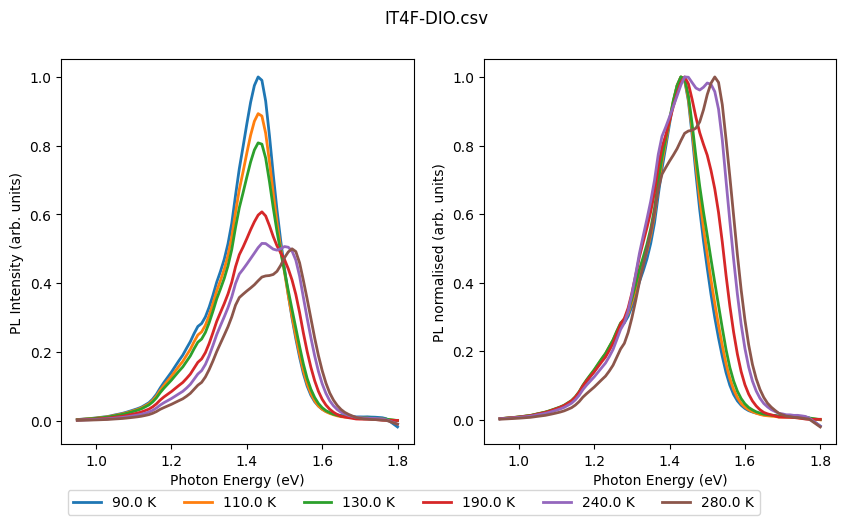

In [4]:
# choose the data to be analysed
# and plot them

csv_name=csv_files[6]
print(csv_name)
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fig,ax = Exp_data_utils.plot_PL_data(Exp_data, temperature_list, hws,title=csv_name.split('/')[-1])

In [5]:
temperature_split=[(200.0,310)]
temperature_split[0][0]

200.0

experiemental_data/2023-12-12-Lowtemp-PL/IT4F-DIO_mod_split200.0_split310.csv
experiemental_data/2023-12-12-Lowtemp-PL/IT4F-DIO_mod_split0.0_split200.0.csv
experiemental_data/2023-12-12-Lowtemp-PL/IT4F-DIO_mod_split0_split500.csv


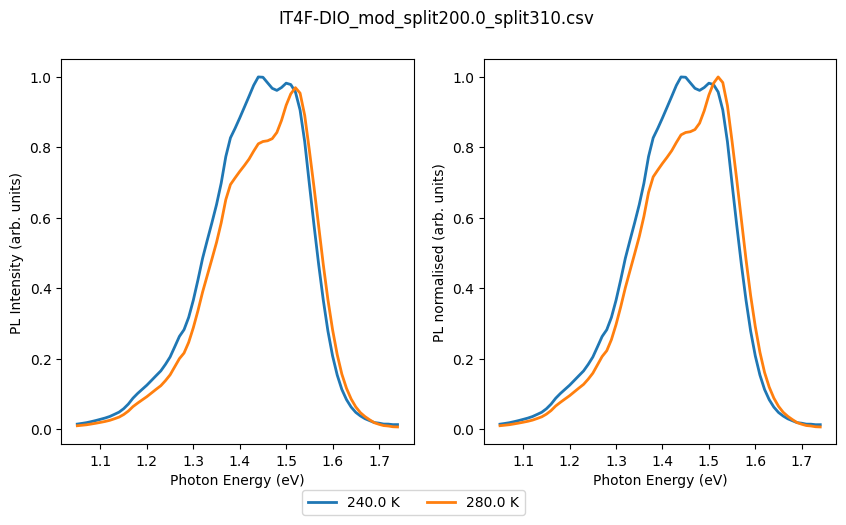

In [6]:
# modify the data if needed
def change_wavelength_range(csv_name,hws_limits=[0.95,1.8],step=0.01,temperature_split=[]):
    data, temperature_list_old, hws_old = Exp_data_utils.read_data(csv_name)
    temperature_split.append((0,500))
    for temp_split in temperature_split:
        temperature_list = temperature_list_old[temperature_list_old>temp_split[0]]
        temperature_list = temperature_list[temperature_list<temp_split[1]]
        list_i = [i for i in range(len(temperature_list_old)) if temperature_list_old[i] in temperature_list]
        hws = np.arange(hws_limits[0], hws_limits[1], step)
        y = np.zeros((hws.size, 1+len(temperature_list)))
        y[:,0] = hws
        for _j,_i in enumerate(list_i):
            f = interpolate.interp1d(hws_old, data[:,_i], axis=0, fill_value='extrapolate')
            y[:,_j+1] = f(hws)
        data_new = np.zeros((len(temperature_list)+1,len(hws)+1))
        data_new[:,1:] = y.transpose()
        data_new[1:,0] = temperature_list
        data_new = pd.DataFrame(data_new, columns=['Temperature']+list(hws))
        data_new.to_csv(f'{csv_name.replace(".csv",f"_mod_split{temp_split[0]}_split{temp_split[1]}.csv")}',index=None,header=None)
        print(f'{csv_name.replace(".csv",f"_mod_split{temp_split[0]}_split{temp_split[1]}.csv")}')
    temp_split = temperature_split[0]
    return f'{csv_name.replace(".csv",f"_mod_split{temp_split[0]}_split{temp_split[1]}.csv")}'
csv_name = change_wavelength_range(csv_name,hws_limits=[1.05,1.75],step=0.01,temperature_split=[(200.0,310),(0.0,200.0)])
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fig,ax = Exp_data_utils.plot_PL_data(Exp_data, temperature_list, hws,title=csv_name.split('/')[-1])

In [7]:
# initialise parameters for the model
import importlib
importlib.reload(config_utils)

(
    number_free_parameters,
    Temp_std_err,
    hws_std_err,
    relative_intensity_std_error_PL,
    sigma,
) = (5, 10, 0.005, 0.05,0.001)
fixed_parameters_dict = {
    "EX":{},
    "CT":{'off':1},  
    "D":{},
}
params_to_fit_init ={
    "EX":{"E":1.37,"sigma":0.001,"Li":7.8e-2,"Lo":0.11,"hO":0.159},
    "CT":{},
    "D":{},
}
min_bounds = {
    "EX":{"E":1.3,"sigma":0.001,"Li":0.03,"Lo":0.03,"hO":0.1},
    "CT":{},
    "D":{},
}
max_bounds = {
    "EX":{"E":1.5,"sigma":0.03,"Li":0.2,"Lo":0.2,"hO":0.2},
    "CT":{},
    "D":{},
}
# save the model config
model_config, test_id = config_utils.save_model_config(
    csv_name_PL=csv_name,
    Temp_std_err=Temp_std_err,
    hws_std_err=hws_std_err,
    relative_intensity_std_error_PL= relative_intensity_std_error_PL,
    temperature_list_PL=temperature_list,
    hws_PL=hws,
    sigma=sigma,
    fixed_parameters_dict=fixed_parameters_dict,
    params_to_fit_init=params_to_fit_init,
    min_bounds=min_bounds,
    max_bounds=max_bounds,
    num_iteration_max_likelihood = 5,
    coeff_spread = 0.5,
    nsteps = 10000,
    num_coords = 32,
    database_folder = "fit_experimental_emcee_PL/fit_data_base/",
    data_folder="fit_experimental_emcee_PL/fit_data/",

)

size of hw is (70,)
size of temperature_list is (2,)


## load model config and check 

In [8]:
# get test_ids in the database
model_config_files = glob.glob('fit_experimental_emcee_PL/fit_data_base/*.json')
test_id_list = []
for id,model_config_file in enumerate(model_config_files):
    print(id,model_config_file)
    test_id = model_config_file.split('/')[-1].replace('.json','')
    test_id_list.append(test_id)
    model_config,model_config_save = config_utils.load_model_config(test_id, database_folder = "fit_experimental_emcee_PL/fit_data_base/")
    print(model_config_save['csv_name_PL'].split('/')[-1])


0 fit_experimental_emcee_PL/fit_data_base/71e8e08a-3e37-4781-bc3a-b15a86ce559b.json
Y6-12mgml-100Canneal_mod_split200.0_split310.csv
1 fit_experimental_emcee_PL/fit_data_base/1c621b75-b7e8-47e8-8d66-42daf517e1b3.json
IT4F-DIO_mod_split200.0_split310.csv


In [9]:
importlib.reload(config_utils)
test_id = test_id_list[0]
model_config,model_config_save = config_utils.load_model_config(test_id, database_folder = "fit_experimental_emcee_PL/fit_data_base/")
fixed_parameters_dict, params_to_fit, min_bound, max_bound = config_utils.get_dict_params(model_config_save)
csv_name = model_config_save['csv_name_PL']
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
print(model_config_save['csv_name_PL'].split('/')[-1])



Y6-12mgml-100Canneal_mod_split200.0_split310.csv


shape of mean value plot is (70, 3)


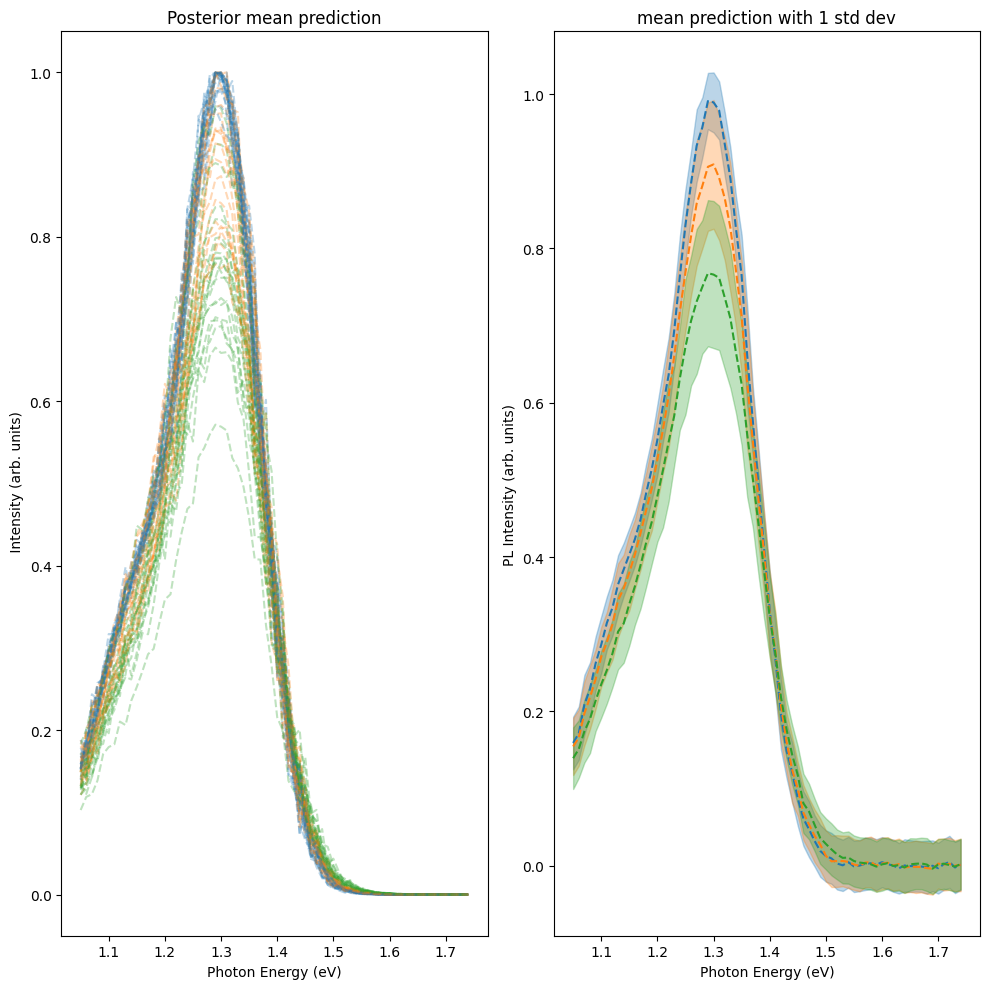

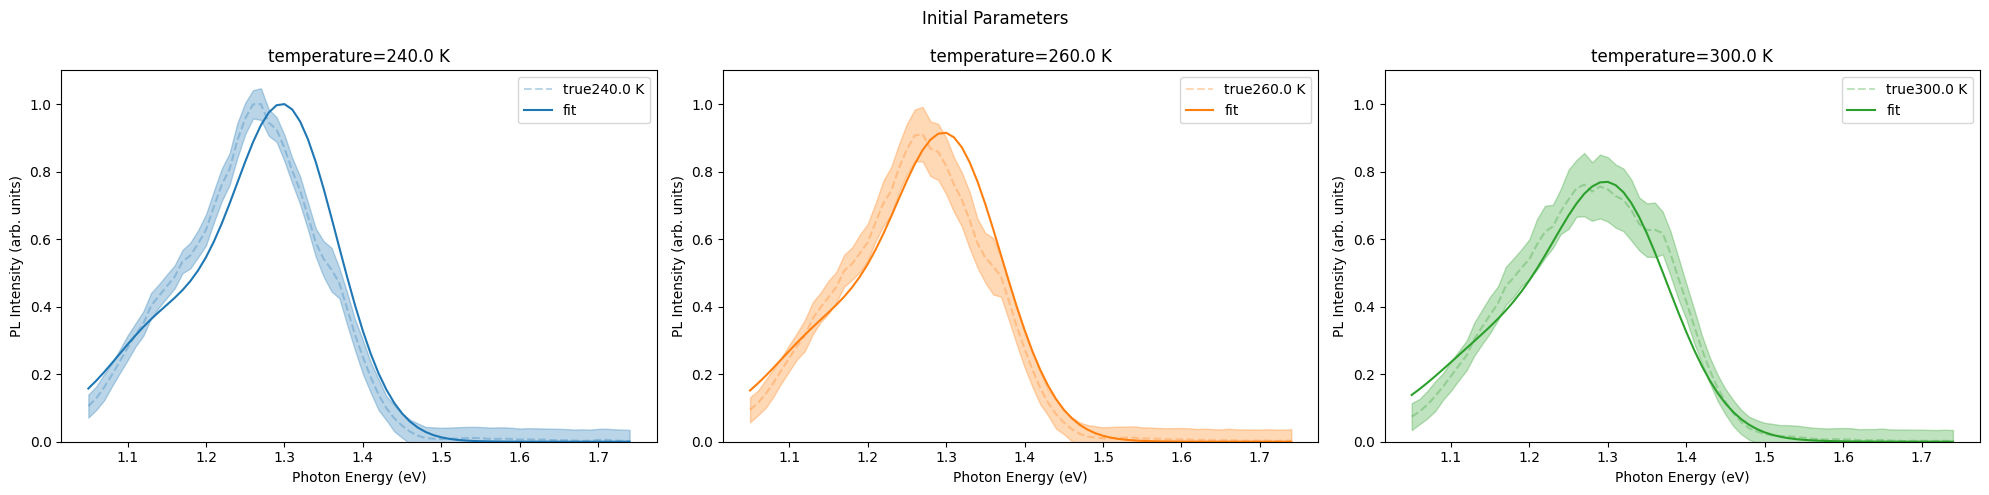

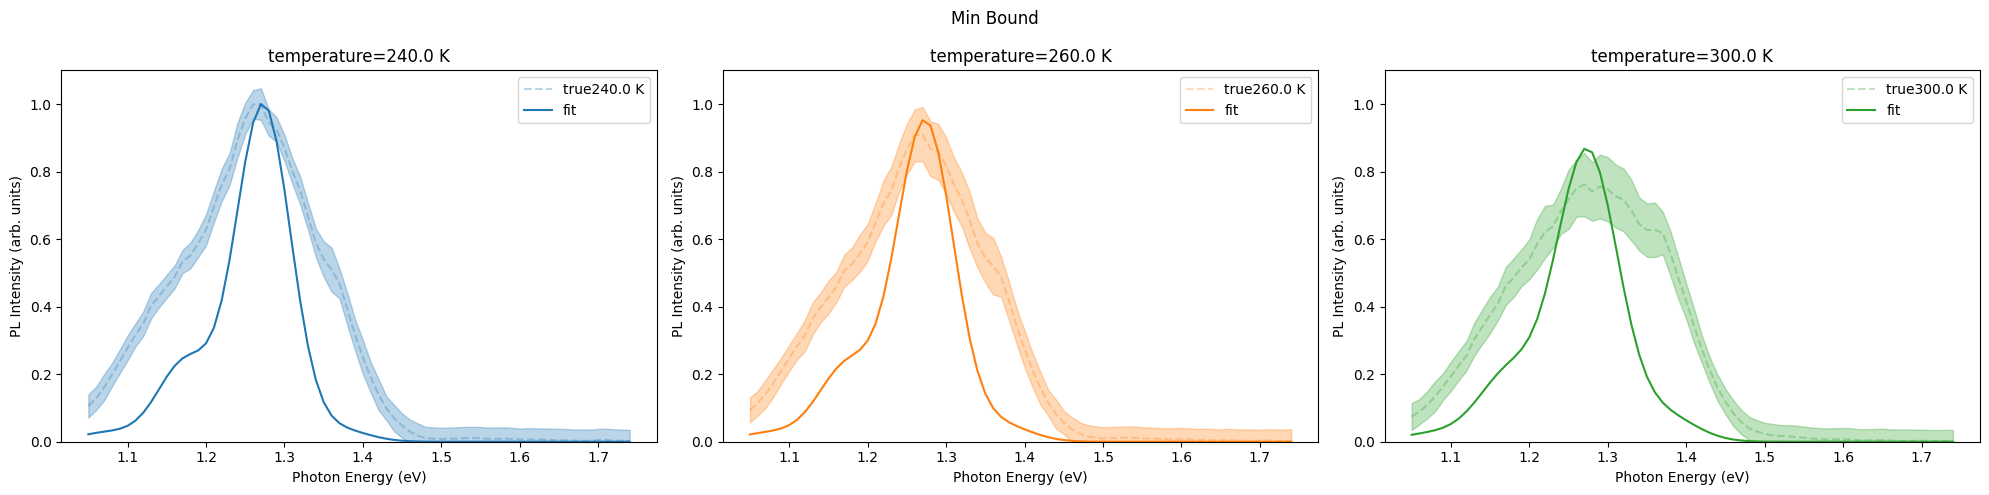

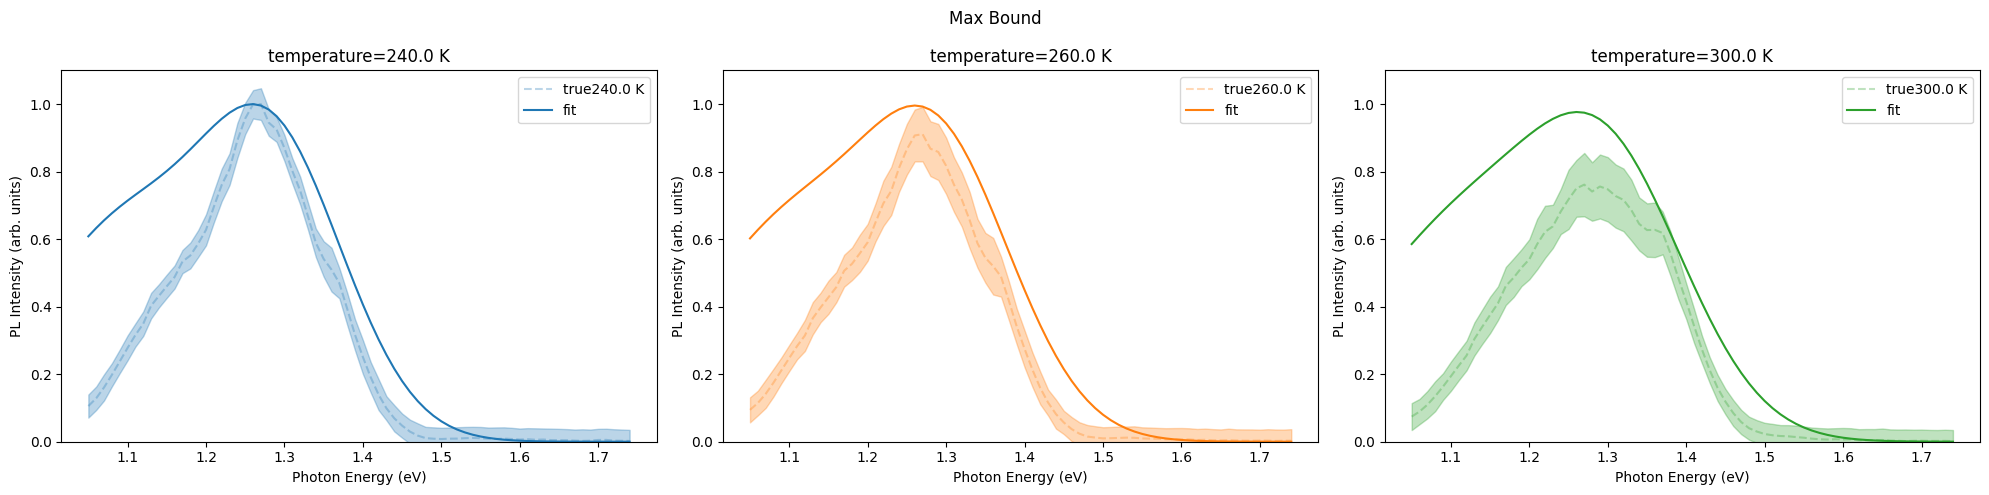

In [10]:
# plot the results with initial parameters
# and the maximum and minumum bounds
from pl_temp_fit import fit_PL_utils
import importlib

importlib.reload(fit_PL_utils)

fit_PL_utils.plot_fit_limits(model_config,model_config_save)

In [11]:
#modify the bounds
import importlib
importlib.reload(config_utils)

(
    number_free_parameters,
    Temp_std_err,
    hws_std_err,
    relative_intensity_std_error_PL,
    sigma,
) = (5, 10, 0.005, 0.05,0.001)
params_to_fit_init ={
    "EX":{"E":1.4,"sigma":0.001,"Li":7.8e-2,"Lo":0.11,"hO":0.159},
    "CT":{},
    "D":{},
}
min_bounds = {
    "EX":{"E":1.3,"sigma":0.001,"Li":0.03,"Lo":0.03,"hO":0.1},
    "CT":{},
    "D":{},
}
max_bounds = {
    "EX":{"E":1.5,"sigma":0.03,"Li":0.2,"Lo":0.2,"hO":0.2},
    "CT":{},
    "D":{},
}
# save the model config
model_config, test_id = config_utils.save_model_config(
    csv_name_PL=csv_name,
    Temp_std_err=Temp_std_err,
    hws_std_err=hws_std_err,
    relative_intensity_std_error_PL= relative_intensity_std_error_PL,
    temperature_list_PL=temperature_list,
    hws_PL=hws,
    sigma=sigma,
    fixed_parameters_dict=fixed_parameters_dict,
    params_to_fit_init=params_to_fit_init,
    min_bounds=min_bounds,
    max_bounds=max_bounds,
    num_iteration_max_likelihood = 5,
    coeff_spread = 0.5,
    nsteps = 10000,
    num_coords = 32,
    database_folder = "fit_experimental_emcee_PL/fit_data_base/",
    data_folder="fit_experimental_emcee_PL/fit_data/",
    test_id = test_id

)

size of hw is (70,)
size of temperature_list is (3,)
